In [235]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
import pandas as pd
import os

logging.set_verbosity(logging.ERROR)

In [236]:
regions = ['237' , '132', '239', '48', '107', '164', '162', '90', '170', '138']
# load the CSV dataset
plot_df = pd.read_csv("merged_taxi.csv")
plot_df.set_index('date', inplace = True)

region = '237'
plot_df = pd.DataFrame(plot_df[region])


date_array = plot_df.index.to_numpy()
time = np.arange(len(date_array))
series = plot_df[region].to_numpy()

time = time[:1094]
series = series[:1094]

In [237]:

def plot_series(time, series, format="-", start=0, end=None, labels=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int or tuple of arrays) - contains the measurements for each time step
      format - line style when plotting the graph
      labels (list of str) - tags for the lines
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
        if labels is None:
            labels = [None] * len(series)
        for series_num, label in zip(series, labels):
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format, label=label)
    else:
        # Plot the time series data
        plt.plot(time[start:end], series[start:end], format, label=labels)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Display the legend
    if labels is not None:
        plt.legend()

    # Draw the graph on screen
    plt.show()
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    times, temperatures = time , series
    TIME = np.array(times)
    SERIES = np.array(series)
    SPLIT_TIME = 1002
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def compute_metrics(true_series, forecast):
    
    # Calculate MAPE manually
    mape = tf.reduce_mean(tf.abs((true_series - forecast) / true_series)) * 100
    print('MAPE:', mape.numpy())

    return mape

In [238]:


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


<Figure size 1000x600 with 0 Axes>

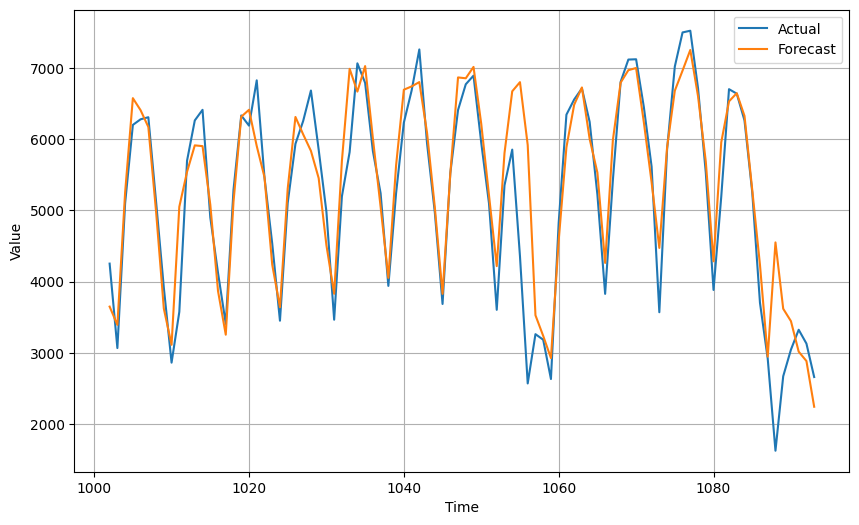

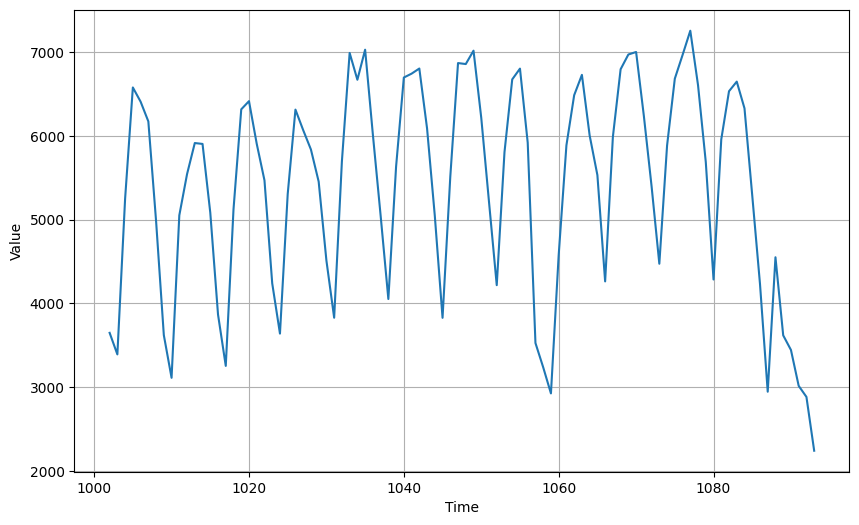

In [239]:
model_file_path = f'saved_model/model_R{region}.h5'
model2 = tf.keras.models.load_model(model_file_path)
# Compute the forecast for all the series
rnn_forecast = model_forecast(model2, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
# rnn_forecast = rnn_forecast

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, (series_valid,rnn_forecast), labels=["Actual", "Forecast"])
plot_series(time_valid, rnn_forecast)

In [240]:
mask = series_valid != 0
series_valid_safe = series_valid[mask]
rnn_forecast_safe = rnn_forecast[mask]

mape = tf.reduce_mean(tf.abs((series_valid_safe - rnn_forecast_safe) / rnn_forecast_safe)) * 100
print('MAPE:', mape.numpy())

MAPE: 7.840847927085641


In [ ]:
def getRMSE(series, forecast):
    return np.sqrt(np.mean(np.square(series - forecast)))

In [282]:


stoplims =[910,1002,1094]
startlims =[819,910,1002]

plot_df = pd.read_csv("merged_taxi.csv")
plot_df.set_index('date', inplace = True)

In [283]:
rmses =[]
for i in range(3):
    # regions = ['237' , '132', '239', '48', '107', '164', '162', '90', '170', '138']
    # load the CSV dataset
    

    region = '138'
    plot_df = pd.DataFrame(plot_df[region])


    date_array = plot_df.index.to_numpy()
    time = np.arange(len(date_array))
    series = plot_df[region].to_numpy()

    time = time[:stoplims[i]]
    series = series[:stoplims[i]]

    @dataclass
    class G:
        times, temperatures = time , series
        TIME = np.array(times)
        SERIES = np.array(series)
        SPLIT_TIME = startlims[i]
        WINDOW_SIZE = 64
        BATCH_SIZE = 32
        SHUFFLE_BUFFER_SIZE = 1000

    # Split the dataset
    time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_TIME)

    # Apply the transformation to the training set
    train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

    model_file_path = f'saved_model/model_R{region}.h5'
    
    model2 = tf.keras.models.load_model(model_file_path)
    # Compute the forecast for all the series
    rnn_forecast = model_forecast(model2, G.SERIES, G.WINDOW_SIZE).squeeze()

    # Slice the forecast to get only the predictions for the validation set
    rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
    # rnn_forecast = rnn_forecast

    mse = tf.keras.losses.MeanSquaredError()(series_valid, rnn_forecast).numpy()
    # mae = tf.keras.losses.MeanAbsoluteError()(series_valid, rnn_forecast).numpy()
    rmse = np.sqrt(mse)
    print("period set", i)
    print(rmse)
    rmses.append(rmse)

print('all values', rmses)

# Calculate the variance
variance = np.var(rmses)

print(f'Variance for region {region} :', variance)


    

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
period set 0
107.93295


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
period set 1
291.04352
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
period set 2
596.51184
all values [107.93295, 291.04352, 596.51184]
Variance for region 138 : 40616.637
